# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy
import os
import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier

from DrTorch.metrics import F1_Score_Multi_Labels
from models.bertFull import BertFull


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.1.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [3]:
if device != 'mps':
    !nvidia-smi


## Defining flags and variables

In [4]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "bert-base-uncased"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
display_utterance(dataframe=df, utterance_id='utterance_3491')
display_utterance(dataframe=df, utterance_id='utterance_456')
display_utterance(dataframe=df, utterance_id='utterance_2005')


Utterance 3491


,speakers,emotions,utterances,triggers
0,Phoebe,surprise,You-you you had sex with Ursula?!,0.0
1,Eric,fear,"Uh, a little bit. She-she-she walked in and I ...",0.0
2,Phoebe,surprise,You didn't notice she was wearing different cl...,1.0
3,Eric,sadness,Well I was just so excited to see you.,0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


[START] frase1_dialogo1 [SEP] frase2_dialogo1 [SEP] ... [END]
[START] frase1_dialogo2 [SEP] ...
...

Frase, speaker, id_dialogo

In [7]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


In [8]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")

Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


In [9]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers
index,,,,
utterance_3646,"[Phoebe, Mike, Phoebe, Mike, Phoebe, Mike, Pho...","[neutral, neutral, neutral, neutral, surprise,...","[Hey Mikey, Hey P, What are you doing?, Settin...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]"
utterance_770,"[Danny, Joey, Chandler, Joey, Chandler, Krista...","[disgust, neutral, surprise, neutral, disgust,...",[so we finally get to the top of the mountain ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3409,"[Chandler, Joey, Chandler]","[anger, neutral, neutral]","[Hey! Hold on a minute, hold on a second. Do y...","[0.0, 1.0, 0.0]"
utterance_3954,"[Monica, Monica, Phoebe, Joey, Joey, Joey, Rac...","[disgust, disgust, anger, sadness, surprise, a...","[Dad, please don't pick your teeth out here!, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_2682,"[Monica, Chandler, Monica, Chandler]","[neutral, joy, surprise, neutral]","[I can't, Oh! Look at that, time's up! My turn...","[0.0, 0.0, 1.0, 0.0]"


,speakers,emotions,utterances,triggers
index,,,,
utterance_2235,"[Joey, Chandler, Phoebe, Joey, Monica, Joey, C...","[anger, neutral, neutral, neutral, neutral, sa...",[Of course! Only an idiot would wear this stuf...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_2992,"[Rachel, Mr. Treeger, Rachel, Mr. Treeger]","[fear, neutral, joy, anger]","[Oh! Hey, Mr. Treeger., : What are you doing?,...","[0.0, 0.0, 1.0, 1.0]"
utterance_601,"[Ross, Ross, Ross, Ross, Ross, Ross, Rachel, R...","[neutral, neutral, neutral, neutral, neutral, ...","[Yes, hello., I have a question., Umm, I used ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
utterance_3077,"[Phoebe, Joey, Phoebe, Joey]","[joy, neutral, neutral, surprise]","[Oh hey! How was your audition?, I'm sorry, do...","[1.0, 0.0, 1.0, 1.0]"
utterance_2587,"[Ross, Rachel, Ross, Rachel, Ross, Ross, Ross,...","[neutral, surprise, joy, surprise, neutral, jo...","[Oh. Oh-oh., Hey! What happened to you? Why ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


,speakers,emotions,utterances,triggers
index,,,,
utterance_3097,"[Phoebe, Joey, Phoebe, Joey, Phoebe]","[neutral, neutral, neutral, neutral, joy]","[Okay, so we got some more good rejections, lo...","[1.0, 0.0, 0.0, 0.0, 1.0]"
utterance_2343,"[Rachel, Phoebe, Rachel, Phoebe, Rachel, Rache...","[neutral, neutral, surprise, neutral, sadness,...","[Phoebe?, Yeah?, Look at that guy by the windo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3145,"[Monica, Chandler, Monica, Chandler, Ross, Cha...","[sadness, neutral, anger, neutral, surprise, a...","[Look, I wanted to tell I'm-I'm sorry you lost...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
utterance_1200,"[Phoebe, Rachel, Phoebe, Rachel, Phoebe, Ross,...","[neutral, joy, neutral, anger, neutral, joy, j...","[Joseph Francis Tribbiani are you home yet?!!,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
utterance_2339,"[Ross, Rachel, Ross, Rachel, Rachel, Rachel, R...","[neutral, neutral, neutral, anger, anger, neut...","[Hey. Who's that?, New people., What happened ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"


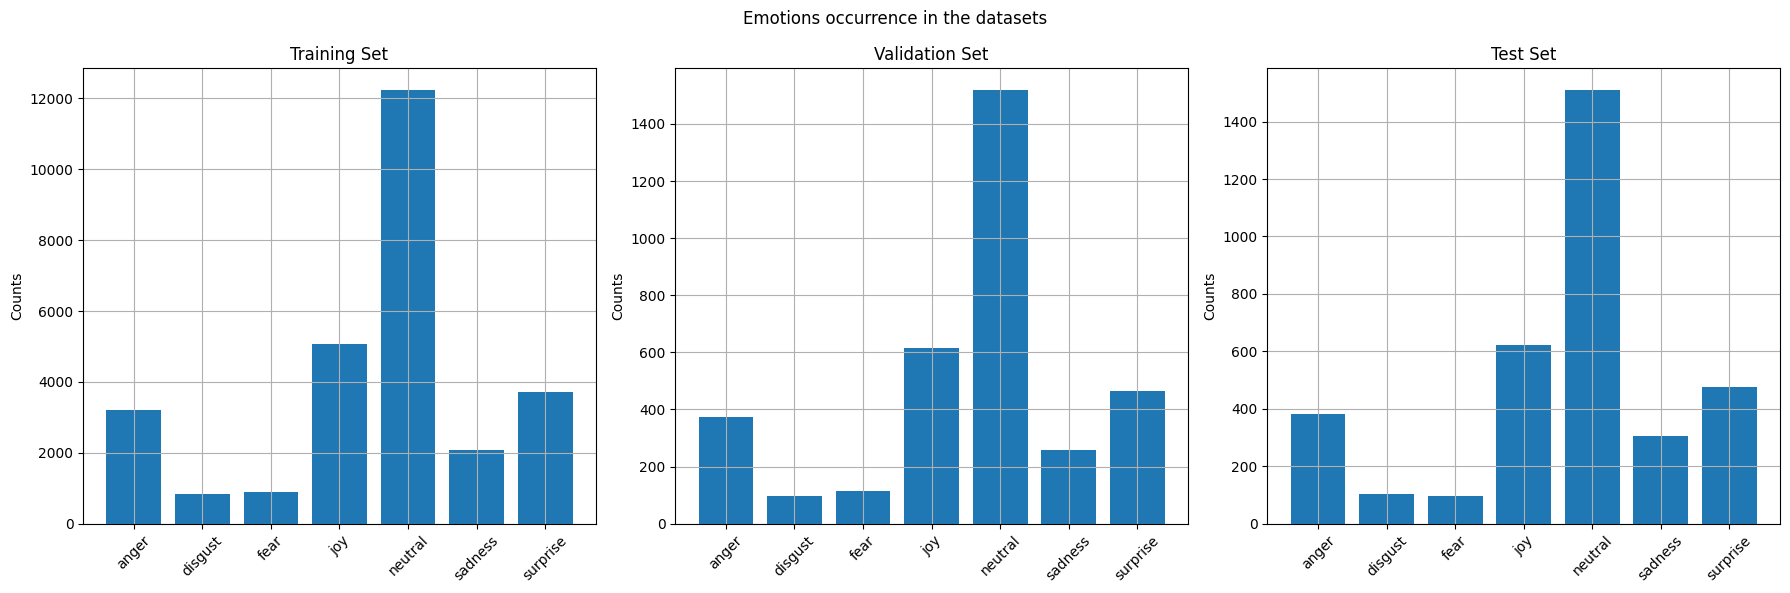

In [10]:
plot_emotion_distribution(train_df, val_df, test_df)


In [11]:
# todo heatmap che associa a ogni personaggio il conto di emozioni che lo riguardano. Ogni riga contiene un'emozione, ogni colonna un personaggio. Esempio:
# Kristen -> (angry-40 volte), (joy, 20 volte), (disgust, 70 volte)...
# Joey -> (angry-23 volte), (joy, 50 volte) ...

# può essere interessante da fare per far vedere che facendo l'embedding dei singoli nomi distintamente il modello avrebbe il bias del nome (magari kristen porta molto disgusto, quindi tende ad assegnarglielo più facilmente)

## Random Classifier

In [12]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
#display_utterance(dataframe=new_test_df, utterance_id='utterance_1125')    

## Majority Classifier

In [13]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
#display_utterance(dataframe=new_test_df, utterance_id='utterance_3881')



## Bert Models

In [14]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_INT = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
INT_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

print("Aaahhh le emozioni: ", EMOTIONS)

Aaahhh le emozioni:  ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


In [15]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY) 

In [16]:
dialogo = [
    "also I was the point person on my company's transition from the KL-5 to GR-6 system.",
    "You must've had your hands full.",
    "That I did. That I did.",
    "So let's talk a little bit about your duties.",
    "My duties? All right."
]

# Preparazione dell'input
tokens = [bert_tokenizer.cls_token]  # Inizia con [CLS]
for frase in dialogo:
    tokens += bert_tokenizer.tokenize(frase) + [bert_tokenizer.sep_token]  # Aggiungi frase e [SEP]

# Converti in ID e tronca se necessario
input_ids = bert_tokenizer.convert_tokens_to_ids(tokens)[:512]  # Assicurati di non superare il limite di 512 token

input_ids_tensor = torch.tensor([input_ids])
print(np.shape(input_ids_tensor))
print(bert_tokenizer.sep_token)


torch.Size([1, 65])
[SEP]


In [17]:
from models.bertFreezed import BertFreezed

pos = [idx for idx in range(len(input_ids_tensor[0])) if input_ids_tensor[0, idx] == 102]
print(pos)
bertino = BertFreezed(bert_model)
bertino(input_ids_tensor, pos)


[25, 35, 44, 57, 64]


(tensor([[-0.4554, -0.1090,  0.5546,  0.1330,  0.0221, -0.4100,  0.2645],
         [-0.1820, -0.0339,  0.5179,  0.1384, -0.0638, -0.4150, -0.0074],
         [-0.4510, -0.1067,  0.5545,  0.1330,  0.0199, -0.4110,  0.2591],
         [-0.5140, -0.1453,  0.5528,  0.1339,  0.0523, -0.3926,  0.3395],
         [-0.0207, -0.0277,  0.4874,  0.1258, -0.0723, -0.4069, -0.1311]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.5128, 0.5018],
         [0.4917, 0.5189],
         [0.5122, 0.5022],
         [0.5228, 0.4968],
         [0.4907, 0.5254]], grad_fn=<SigmoidBackward0>))